# Modified q-voter model with the echo chamber effect 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 3000000
nSaveSteps: 1
nRuns: 1
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: false
comorbidities: false
qVoterParameters:
  p: 0.2
  q: 6
epidemicLayerParameters:
  beta: 0.1
  zeta: 0.5 # attitude towards vaccination
  alpha: 0.9 # effectiveness of the vaccination
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 1.0
proPisFraction: 0.45
pisVaccinationCorrelation: 0.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/test_filter_bubbles
firstParameterRange:
  start: 0.0
  end: 0.5
  count: 51
  vals: null
  type: p
secondParameterRange:
  start: 0.0
  end: 0.0
  count: 0
  vals: [3, 4, 5, 6]
  type: q
thirdParameterRange: null
linksRemoval: false
nQVoterPerStep: 1
vaccinationFraction: 0.0
neglectNeighboursPiS: false
filterBubble: false
```


In [23]:
def load_df(prefix, fracPos, q, folder, p, qvotersteps, nagents=10000, nsteps=3000000, nruns=1):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q={q}_PIS=0.0_EPIDEMIC=beta=0.10_zeta=0.50_alpha=0.90_gamma=0.50_mu=0.90_kappa=0.10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    return dfs1


ps = ['{:.2f}'.format(x / 100) for x in list(range(51))]
qs = [3, 4, 5, 6]

fracPos = ['1.0']

print('ps: ', ps)
print('Opinion fraction: ', fracPos)
print('qs: ', qs)

ps:  ['0.00', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.17', '0.18', '0.19', '0.20', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26', '0.27', '0.28', '0.29', '0.30', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39', '0.40', '0.41', '0.42', '0.43', '0.44', '0.45', '0.46', '0.47', '0.48', '0.49', '0.50']
Opinion fraction:  ['1.0']
qs:  [3, 4, 5, 6]


In [24]:
def load_dfs(fracPos, qvotersteps, ps=ps, qs=qs,
             path='test_filter_bubbles'):
    """
    ( { beta: list of dataframes, one per `p` value }, { beta: list of dataframes, one per `p` value } )
    one for removal link strategy, second one without it
    
    e.g.

    ({'0.01': [pd.DataFrame(p=0.00), pd.DataFrame(p=0.01), ...]}, ... )
    """
    on_p = {}
    off_p = {}
    for q in tqdm(qs):
        off_p_per_q = []
        on_p_per_q = []
        for p in ps:
            df1 = load_df('off', fracPos, q, path, p, qvotersteps)
            df2 = load_df('on', fracPos, q, path, p, qvotersteps)
            off_p_per_q.append(df1)
            on_p_per_q.append(df2)
        off_p[q] = off_p_per_q
        on_p[q] = on_p_per_q
    return on_p, off_p



def load_all_dfs(fracPos, qvotersteps_all, ps=ps, qs=qs):
    """
    { qvoterstep: {beta: list of dataframes}, ... }
    """
    df_per_qvotersteps_on = {}
    df_per_qvotersteps_off = {}
    for qvotersteps in qvotersteps_all:
        df_per_qvotersteps_on[qvotersteps], df_per_qvotersteps_off[qvotersteps] = \
            load_dfs(fracPos, qvotersteps, ps=ps, qs=qs)
    
    return df_per_qvotersteps_on, df_per_qvotersteps_off 

In [25]:
%%time

qvotersteps_all = [1]

pos_on, pos_off = load_all_dfs('1.0', qvotersteps_all, ps=ps, qs=qs)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 2.84 s, sys: 14 ms, total: 2.85 s
Wall time: 2.84 s


In [26]:
def time_max_infected(dfs):
    times = []
    for df in dfs:
        t = df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]
        times.append(t)
    return np.array(times)
    
def max_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].max()
        val.append(i)
    return np.array(val)

def last_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].to_numpy()[-1]
        val.append(i)
    return np.array(val)


def time_to_no_susceptible(dfs):
    val = []
    for df in dfs:
        i = df[df['susceptibleRate'] < 1e-2].step.values
        if len(i) >= 1:
            val.append(i[0])
        else:
            val.append(0)
    return val

In [34]:
colormap = plt.cm.get_cmap('gnuplot', len(qvotersteps_all))
colors = [colormap(i) for i in range(len(qvotersteps_all))]


def plot_p_vs_fun(fracDfs, beta, fun, ps, colors=colors, ylabel='', ax=None):
    i = 0
    for qvotersteps, dfs in fracDfs.items():
        # label -> qvotersteps
        # dfs[beta] -> all ps
        if ax is None:
            plt.plot(ps, fun(dfs[beta]), label=r'qsteps={}'.format(qvotersteps),
                     color=colors[i])
        else:
            ax.plot(ps, fun(dfs[beta]), label=r'qsteps={}'.format(qvotersteps),
                     color=colors[i])
            
        i += 1
    plt.title(r'$\beta={}$'.format(beta))
    plt.xlabel('p')
    plt.ylabel(ylabel)
    
def plot_all_vals(ys, fun, ylabel, betas, ncol=1):
    i, j = 0, 0
    for y in ys:
        plt.plot(x, fun(y[0]), label=r'with, $\beta={}$'.format(betas[j]), color=colors[i])
        plt.plot(x, fun(y[1]), label=r'without, $\beta={}$'.format(betas[j]), color=colors[i+1])
        i += 2
        j += 1
    plt.legend(loc=(1.01, 0.05), ncol=ncol)
    plt.xlabel('positive opinion fraction')
    plt.ylabel(ylabel)    

In [42]:
def plot_p_vs_fun(fracDfs, q, fun, ps, colors=colors, ylabel='', ax=None):
    i = 0
    for qvotersteps, dfs in fracDfs.items():
        # label -> qvotersteps
        # dfs[beta] -> all ps
        if ax is None:
            plt.scatter(ps, fun(dfs[q]), label=r'qsteps={}'.format(qvotersteps),
                     color=colors[i], s=20)
        else:
            ax.scatter(ps, fun(dfs[q]), label=r'qsteps={}'.format(qvotersteps),
                     color=colors[i])
            
        i += 1
    plt.title(r'$q={}$'.format(q))
    plt.xlabel('p')
    plt.ylabel(ylabel)
    
def plot_p_vs_last_mean_opinion_all_betas(fracDfs, qs=qs):
    ps_float = [float(p) for p in ps]
    f1 = lambda x: last_by_columns(x, 'meanOpinion')
    f2 = lambda x: max_by_columns(x, 'infectedRate')
#     f2 = lambda x: max_by_columns(x, 'quarantinedRate')
    
    plt.figure(figsize=(12, 10))
    i = 1
    for q in qs:
        plt.subplot(2, 2, i)
        
        plot_p_vs_fun(fracDfs, q, f1, ps_float, ylabel='mean opinion')
        i += 1
        if i < 4:
            plt.xlabel('')
        if i != 2 and i != 5:
            plt.ylabel('')
#         plot_p_vs_fun(fracDfs, beta, f2, ps_float, ylabel='infected rate', ax=plt.gca().twinx())
        
    plt.legend(loc=(1.3, 0.2))

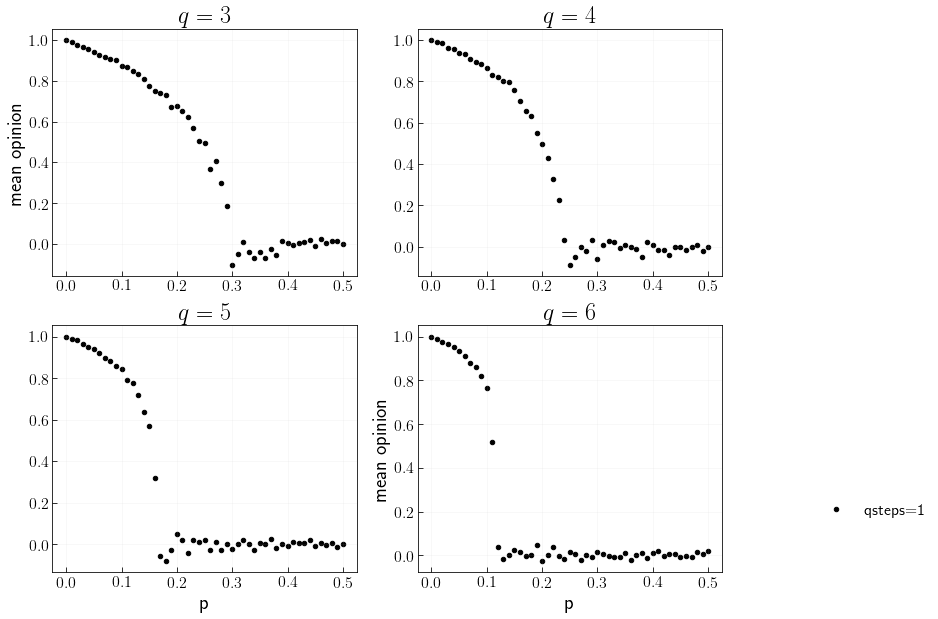

In [43]:
plot_p_vs_last_mean_opinion_all_betas(pos_off)

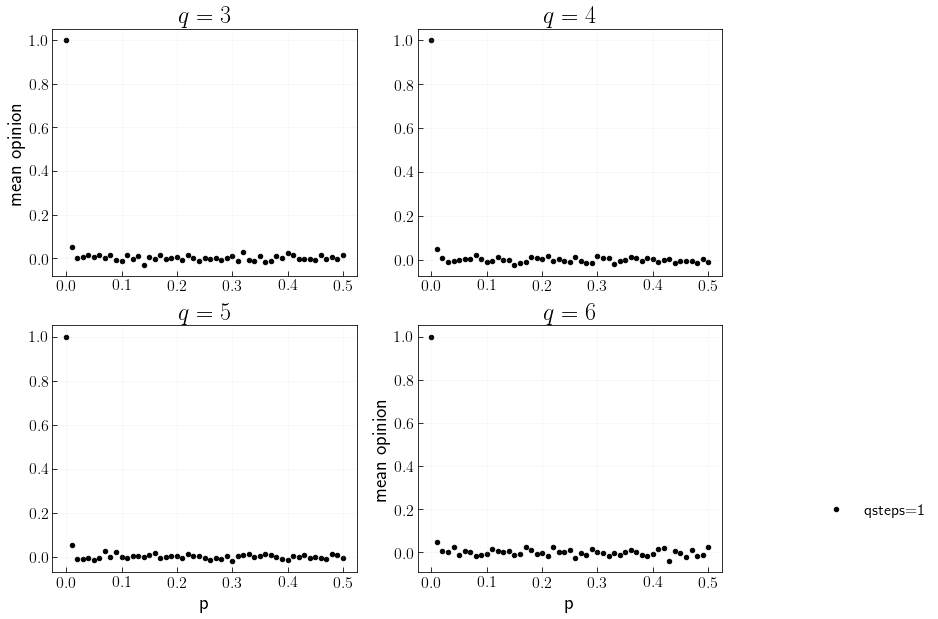

In [44]:
plot_p_vs_last_mean_opinion_all_betas(pos_on)